In [121]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
!{sys.executable} -m pip install lasio

## Petrophysics calculation

In [122]:
import lasio
las=lasio.read('well-1.las') 

#convert the las file to pandas dataframe, this will automatically retain the logname and made the depth as index column
well=las.df()
print (well)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB
DEPTH                                                       
3001.0  9.984  148.500  80.875  0.722  0.991  0.43701  2.170
3001.5  9.938  148.625  80.875  0.718  1.026  0.47705  2.176
3002.0  9.914  146.125  80.625  0.714  0.990  0.45947  2.166
3002.5  9.859  145.375  82.625  0.715  0.953  0.47754  2.158
3003.0  9.914  145.125  81.938  0.709  0.900  0.45508  2.156
...       ...      ...     ...    ...    ...      ...    ...
4458.0  8.484  109.000  79.812  1.122  1.744  0.33252  2.316
4458.5  8.469  109.438  82.312  1.112  1.972  0.34082  2.326
4459.0  8.484  109.562  77.188  1.092  1.959  0.35693  2.316
4459.5  8.461  110.750  75.250  1.079  1.746  0.37256  2.311
4460.0  8.469  110.938  75.188  1.067  1.625  0.36768  2.307

[2919 rows x 7 columns]


In [123]:
KujungFM=well.loc[3337.79:3751.5]
print (KujungFM)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB
DEPTH                                                       
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668
...       ...      ...     ...    ...    ...      ...    ...
3749.5  8.555  130.625  85.000  0.773  0.873  0.43115  2.184
3750.0  8.648  130.875  87.500  0.772  0.891  0.43164  2.170
3750.5  8.680  130.875  86.250  0.775  1.158  0.44092  2.178
3751.0  8.727  129.375  89.188  0.773  1.072  0.42285  2.184
3751.5  8.633  129.500  89.688  0.772  1.035  0.40430  2.191

[828 rows x 7 columns]


In [124]:
#this code is adapted from andy mcdonald

def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min): #specify the arguments
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min) #use the argument to the equation using math operators
    return round(vshale, 4)

def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

In [125]:
mDens= 2.65
fDens= 1
KujungFM['VSHALE']=shale_volume(KujungFM['GR'], KujungFM['GR'].quantile(q=0.99),
                             KujungFM['GR'].quantile(q=0.01))
KujungFM['PHI']=density_porosity(KujungFM['RHOB'], mDens, fDens)
KujungFM.head()

CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB  VSHALE     PHI
DEPTH                                                                       
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264  0.8678  0.2339
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320  0.7119  0.2000
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408  0.5289  0.1467
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562  0.2433  0.0533
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668 -0.0522 -0.0109

### Calculate RW and SW

**Apparent water formation resistivity using Hingle method**
<img src=https://github.com/partsolco/python-geo-20feb2021/blob/main/images/rw.PNG?raw=true>

**SW:**
<img src=https://github.com/partsolco/python-geo-20feb2021/blob/main/images/sw_archie.png?raw=true>

In [126]:
def rw_app(porosity, archieA, archieM, rt):
    rw=((porosity ** archieM) * (rt/archieA))
    return rw

def sw_archie(porosity, rt, rw, archieA, archieM, archieN):
    sw = ((archieA / (porosity ** archieM)) * (rw/rt))**(1/archieN)
    return sw

archieA= 1
archieM= 2
archieN= 2

In [127]:
KujungFM['rw']=rw_app(KujungFM["NPHI_LS"], archieA, archieM, KujungFM["ILD"])
print (KujungFM)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB  VSHALE     PHI  \
DEPTH                                                                          
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264  0.8678  0.2339   
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320  0.7119  0.2000   
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408  0.5289  0.1467   
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562  0.2433  0.0533   
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668 -0.0522 -0.0109   
...       ...      ...     ...    ...    ...      ...    ...     ...     ...   
3749.5  8.555  130.625  85.000  0.773  0.873  0.43115  2.184  0.8040  0.2824   
3750.0  8.648  130.875  87.500  0.772  0.891  0.43164  2.170  0.8458  0.2909   
3750.5  8.680  130.875  86.250  0.775  1.158  0.44092  2.178  0.8249  0.2861   
3751.0  8.727  129.375  89.188  0.773  1.072  0.42285  2.184  0.8741  0.2824   
3751.5  8.633  129.500  89.688  0.772  1

In [128]:
KujungFM['SW'] = sw_archie(KujungFM["NPHI_LS"], KujungFM["ILD"], KujungFM["rw"], archieA, archieM, archieN)
print(KujungFM)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB  VSHALE     PHI  \
DEPTH                                                                          
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264  0.8678  0.2339   
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320  0.7119  0.2000   
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408  0.5289  0.1467   
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562  0.2433  0.0533   
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668 -0.0522 -0.0109   
...       ...      ...     ...    ...    ...      ...    ...     ...     ...   
3749.5  8.555  130.625  85.000  0.773  0.873  0.43115  2.184  0.8040  0.2824   
3750.0  8.648  130.875  87.500  0.772  0.891  0.43164  2.170  0.8458  0.2909   
3750.5  8.680  130.875  86.250  0.775  1.158  0.44092  2.178  0.8249  0.2861   
3751.0  8.727  129.375  89.188  0.773  1.072  0.42285  2.184  0.8741  0.2824   
3751.5  8.633  129.500  89.688  0.772  1

In [129]:
KujungFM.describe()

CALI          DT          GR         ILD        MSFL     NPHI_LS  \
count  828.000000  828.000000  828.000000  828.000000  828.000000  828.000000   
mean     8.588909  118.736715   76.343841    1.109170    1.743801    0.381769   
std      0.340040   12.152890   13.450552    0.408286    3.261412    0.053883   
min      7.680000   57.625000   17.641000    0.563000    0.460000    0.119630   
25%      8.344000  110.531000   69.188000    0.864750    1.119000    0.349120   
50%      8.539000  119.375000   79.750000    1.061000    1.343500    0.387700   
75%      8.758000  128.031250   85.453500    1.267250    1.583000    0.419920   
max     10.422000  156.250000  101.188000    6.004000   42.829000    0.486330   

             RHOB      VSHALE         PHI          rw            SW  
count  828.000000  828.000000  828.000000  828.000000  8.280000e+02  
mean     2.225851    0.659101    0.257057    0.154674  1.000000e+00  
std      0.071534    0.225129    0.043354    0.032237  4.316309e-17  
min      1.875000   -0.323400   -0.041800    0.039200  1.000000e+00  
25%      2.188000    0.539300    0.238800    0.133070  1.000000e+00  
50%      2.230000    0.716100    0.254500    0.152117  1.000000e+00  
75%      2.256000    0.811575    0.280000    0.173003  1.000000e+00  
max      2.719000    1.074900    0.469700    0.343277  1.000000e+00

## Data Handling

- ***explore the statistical information of the SW and RW log***
- ***compare the mean and the standard deviation of each log from the pandas result***
- ***visualize using histogram, boxplot, etc***

In [130]:
import pandas as pd



In [131]:
print ('mean for all variables in KujungFM: \n' + str(KujungFM.mean())+'\n')
print ('median for all variables in KujungFM: \n' + str(KujungFM.median()))

mean for all variables in KujungFM: 
CALI         8.588909
DT         118.736715
GR          76.343841
ILD          1.109170
MSFL         1.743801
NPHI_LS      0.381769
RHOB         2.225851
VSHALE       0.659101
PHI          0.257057
rw           0.154674
SW           1.000000
dtype: float64

median for all variables in KujungFM: 
CALI         8.539000
DT         119.375000
GR          79.750000
ILD          1.061000
MSFL         1.343500
NPHI_LS      0.387700
RHOB         2.230000
VSHALE       0.716100
PHI          0.254500
rw           0.152117
SW           1.000000
dtype: float64


In [133]:
print ('range for all variables in KujungFM: \n' + str(KujungFM.max()-KujungFM.min())+'\n')
print ('variance for all variables in KujungFM: \n' + str(KujungFM.var())+'\n')
print ('standard deviation for all variables in KujungFM: \n'+ str(KujungFM.std()))

range for all variables in KujungFM: 
CALI       2.742000e+00
DT         9.862500e+01
GR         8.354700e+01
ILD        5.441000e+00
MSFL       4.236900e+01
NPHI_LS    3.667000e-01
RHOB       8.440000e-01
VSHALE     1.398300e+00
PHI        5.115000e-01
rw         3.040771e-01
SW         1.110223e-16
dtype: float64

variance for all variables in KujungFM: 
CALI       1.156269e-01
DT         1.476927e+02
GR         1.809174e+02
ILD        1.666978e-01
MSFL       1.063681e+01
NPHI_LS    2.903326e-03
RHOB       5.117104e-03
VSHALE     5.068322e-02
PHI        1.879568e-03
rw         1.039209e-03
SW         1.863052e-33
dtype: float64

standard deviation for all variables in KujungFM: 
CALI       3.400395e-01
DT         1.215289e+01
GR         1.345055e+01
ILD        4.082864e-01
MSFL       3.261412e+00
NPHI_LS    5.388252e-02
RHOB       7.153393e-02
VSHALE     2.251293e-01
PHI        4.335398e-02
rw         3.223677e-02
SW         4.316309e-17
dtype: float64


In [134]:
print(KujungFM.describe())

             CALI          DT          GR         ILD        MSFL     NPHI_LS  \
count  828.000000  828.000000  828.000000  828.000000  828.000000  828.000000   
mean     8.588909  118.736715   76.343841    1.109170    1.743801    0.381769   
std      0.340040   12.152890   13.450552    0.408286    3.261412    0.053883   
min      7.680000   57.625000   17.641000    0.563000    0.460000    0.119630   
25%      8.344000  110.531000   69.188000    0.864750    1.119000    0.349120   
50%      8.539000  119.375000   79.750000    1.061000    1.343500    0.387700   
75%      8.758000  128.031250   85.453500    1.267250    1.583000    0.419920   
max     10.422000  156.250000  101.188000    6.004000   42.829000    0.486330   

             RHOB      VSHALE         PHI          rw            SW  
count  828.000000  828.000000  828.000000  828.000000  8.280000e+02  
mean     2.225851    0.659101    0.257057    0.154674  1.000000e+00  
std      0.071534    0.225129    0.043354    0.032237  4.316

In [135]:
import matplotlib.pyplot as plt

import seaborn as sns

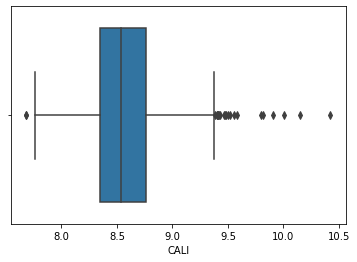

In [136]:
sns.boxplot(KujungFM["CALI"])
plt.show()

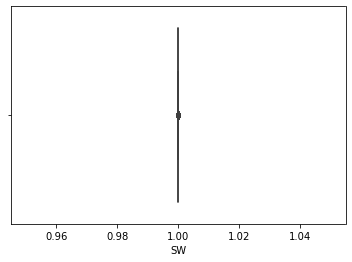

In [137]:
sns.boxplot(KujungFM["SW"])
plt.show()

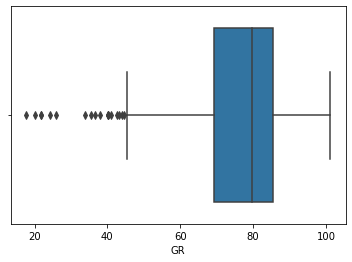

In [138]:
sns.boxplot(KujungFM["GR"])
plt.show()

In [139]:
print(KujungFM)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB  VSHALE     PHI  \
DEPTH                                                                          
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264  0.8678  0.2339   
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320  0.7119  0.2000   
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408  0.5289  0.1467   
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562  0.2433  0.0533   
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668 -0.0522 -0.0109   
...       ...      ...     ...    ...    ...      ...    ...     ...     ...   
3749.5  8.555  130.625  85.000  0.773  0.873  0.43115  2.184  0.8040  0.2824   
3750.0  8.648  130.875  87.500  0.772  0.891  0.43164  2.170  0.8458  0.2909   
3750.5  8.680  130.875  86.250  0.775  1.158  0.44092  2.178  0.8249  0.2861   
3751.0  8.727  129.375  89.188  0.773  1.072  0.42285  2.184  0.8741  0.2824   
3751.5  8.633  129.500  89.688  0.772  1

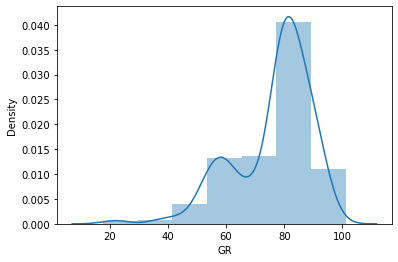

In [140]:
sns. distplot(KujungFM[ 'GR' ], bins=7)
plt. show()

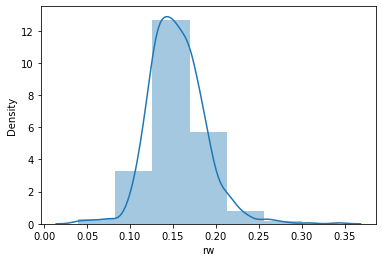

In [141]:
sns. distplot(KujungFM[ 'rw' ], bins=7)
plt. show()

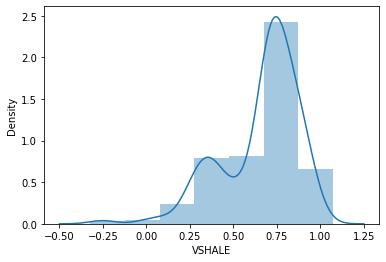

In [142]:
sns. distplot(KujungFM[ 'VSHALE' ], bins=7)
plt. show()

In [143]:
KujungFM = pd.read_csv('partsol_basicml.csv')


In [144]:
KujungFM.head()

X1     X2      X3     X4     Y1
0  514.5  294.0  110.25  15.55  21.33
1  514.5  294.0  110.25  15.55  21.33
2  514.5  294.0  110.25  15.55  21.33
3  514.5  294.0  110.25  15.55  21.33
4  563.5  318.5  122.50  20.84  28.28

In [145]:
X = KujungFM[['X1','X2','X3','X4']]
y = KujungFM['Y1']

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)

LinearRegression()

In [146]:
KujungFM['Ypred'] = reg.predict(X)

In [147]:
KujungFM.head()

X1     X2      X3     X4     Y1      Ypred
0  514.5  294.0  110.25  15.55  21.33  19.952873
1  514.5  294.0  110.25  15.55  21.33  19.952873
2  514.5  294.0  110.25  15.55  21.33  19.952873
3  514.5  294.0  110.25  15.55  21.33  19.952873
4  563.5  318.5  122.50  20.84  28.28  24.246169

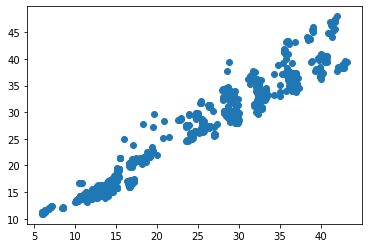

In [148]:
plt.figure()
plt.scatter(KujungFM.X4,KujungFM.Y1)
plt.show()

In [149]:
from sklearn.cluster import KMeans
clus = KujungFM[['X4','Y1']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(clus)
KujungFM["clusters"]=kmeans.labels_

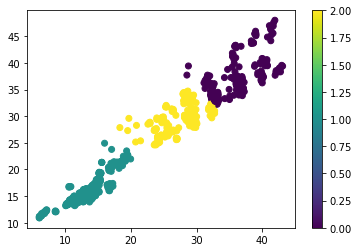

In [150]:
plt.figure()
plt.scatter(KujungFM.X4, KujungFM.Y1, c=KujungFM.clusters)
plt.colorbar()
plt.show()

In [151]:
print(KujungFM[ KujungFM[ 'clusters' ] ==2])

        X1     X2     X3     X4     Y1      Ypred  clusters
4    563.5  318.5  122.5  20.84  28.28  24.246169         2
5    563.5  318.5  122.5  21.46  25.38  24.780574         2
6    563.5  318.5  122.5  20.71  25.16  24.134116         2
7    563.5  318.5  122.5  19.68  29.60  23.246314         2
8    588.0  294.0  147.0  19.50  27.30  22.761513         2
..     ...    ...    ...    ...    ...        ...       ...
729  588.0  294.0  147.0  31.81  31.20  33.372044         2
732  612.5  318.5  147.0  30.00  29.93  31.718175         2
733  612.5  318.5  147.0  29.50  29.56  31.287203         2
734  612.5  318.5  147.0  29.06  33.84  30.907948         2
735  612.5  318.5  147.0  29.92  32.54  31.649220         2

[184 rows x 7 columns]


In [152]:
print(KujungFM. clusters. unique())

[1 2 0]


In [153]:
#inertia score determination
score = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_predict(clus)
    score.append(kmeans.inertia_) # average of distance between points in one cluster

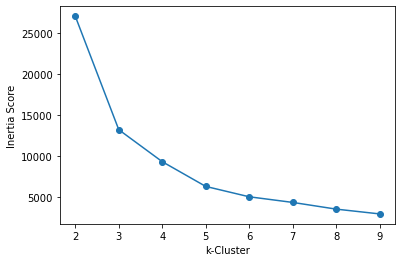

In [154]:
import numpy as np
#plotting elbow method

plt.figure()
plt.plot(np.arange(2,10), score)
plt.scatter(np.arange(2,10), score)
plt.xlabel("k-Cluster")
plt.ylabel("Inertia Score")
plt.show()

In [155]:
import warnings
warnings.filterwarnings('ignore')

#Load well train
import pandas as pd
KujungFM = pd.read_csv('well_train.csv') #load data from CSV
print(KujungFM)

#load testing well
KujungFM_target = pd.read_csv('well_test.csv')
X_test = KujungFM_target
print(X_test)


          DEPT         GR     RHOB          VP  FACIES
0    4940.0460  150.07190  2.72833  3820.24268       1
1    4940.1984  153.27740  2.72637  3798.05396       1
2    4940.3508  155.58180  2.72202  3775.34277       1
3    4940.5032  155.97696  2.72029  3764.78662       1
4    4940.6556  153.99037  2.72137  3766.25977       1
..         ...        ...      ...         ...     ...
455  5009.3880   13.87138  2.48817  4883.83447       0
456  5009.5404   13.30794  2.48556  4878.48975       0
457  5009.6928   12.32699  2.48054  4870.06494       0
458  5009.8452   11.63948  2.47144  4847.33887       0
459  5009.9976   11.40202  2.46054  4809.12109       0

[460 rows x 5 columns]
          DEPT        GR     RHOB          VP
0    4400.0928  51.31930  2.41280  4843.46362
1    4400.2452  51.53658  2.43140  4860.34131
2    4400.3976  48.50318  2.44562  4874.98633
3    4400.5500  42.97136  2.44510  4888.49072
4    4400.7024  36.64860  2.42774  4920.08203
..         ...       ...      ...       

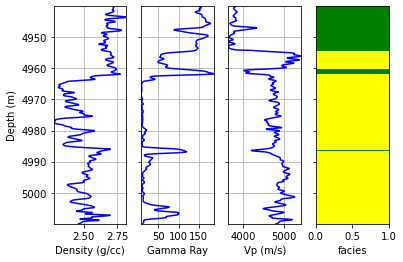

In [156]:
#create well log data plot function

import matplotlib.colors as colors
facies_colors = ['yellow','green'] #yellow and green color
cmap_facies = colors.ListedColormap(facies_colors) #make color into colormap

import matplotlib.pyplot as plt

import numpy as np

#menentukan top dan bottom dari DEPTH
top=KujungFM['DEPT'].max()
bot=KujungFM['DEPT'].min()

#plotting
plt.figure()
plt.subplot(1,4,1)
plt.plot(KujungFM.RHOB, KujungFM.DEPT, color='b')
plt.ylim(top,bot) #menentukan batas bawah dan batas atas (dibalik)
plt.grid()
plt.xlabel("Density (g/cc)")
plt.ylabel('Depth (m)')
plt.xlim(KujungFM.RHOB.min(), KujungFM.RHOB.max()) #menentukan limit RHOB

plt.subplot(1,4,2)
plt.plot(KujungFM.GR, KujungFM.DEPT, color='b')
plt.gca().axes.yaxis.set_ticklabels([]) #menghilangkan angka pada y-axis
plt.ylim(top,bot)
plt.grid()
plt.xlabel("Gamma Ray")
plt.xlim(KujungFM.GR.min(), KujungFM.GR.max())
plt.subplot(1,4,3)
plt.plot(KujungFM.VP, KujungFM.DEPT, color='b')
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylim(top,bot)
plt.grid()
plt.xlabel("Vp (m/s)")
plt.xlim(KujungFM.VP.min(), KujungFM.VP.max())

plt.subplot(1,4,4)
C = np.stack((KujungFM.FACIES, KujungFM.FACIES),axis=1)
#membuat matriks dengan 2 kolom
plt.imshow(C, aspect='auto',extent=[0,1,top,bot],cmap = cmap_facies)
#visualisasi image (bukan plot) dari matrix
plt.gca().axes.yaxis.set_ticklabels([])
plt.xlabel('facies')
plt.ylim(top,bot)

plt.show()


In [157]:
#Split X (predictor) and Y (target)


X = KujungFM.drop(['DEPT','FACIES'],axis = 1)
y = KujungFM['FACIES']
print(X)
print(y)

            GR     RHOB          VP
0    150.07190  2.72833  3820.24268
1    153.27740  2.72637  3798.05396
2    155.58180  2.72202  3775.34277
3    155.97696  2.72029  3764.78662
4    153.99037  2.72137  3766.25977
..         ...      ...         ...
455   13.87138  2.48817  4883.83447
456   13.30794  2.48556  4878.48975
457   12.32699  2.48054  4870.06494
458   11.63948  2.47144  4847.33887
459   11.40202  2.46054  4809.12109

[460 rows x 3 columns]
0      1
1      1
2      1
3      1
4      1
      ..
455    0
456    0
457    0
458    0
459    0
Name: FACIES, Length: 460, dtype: int64


In [158]:
#train and test splitting
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val= train_test_split(X,y, test_size=0.2,  stratify = y, random_state=10)

#stratify y (the proportion of each facies in train and validation data must be the same)
shale_train = int(len(y_train[y_train==1])/len(y_train)*100)

shale_val = int(len(y_val[y_val==1])/len(y_val)*100)

print('shale on training data is ' + str(shale_train) + ' percent')
print('shale on validation data is ' + str(shale_val) + ' percent')

shale on training data is 23 percent
shale on validation data is 23 percent


In [159]:
#Decision Tree Classifier
from sklearn import tree
dtc = tree.DecisionTreeClassifier() #assign model

#fit and predict to train and validation data
dtc.fit(X_train, y_train) #fit model to training data
y_pred_train = dtc.predict(X_train) #predict model to training data
y_pred_val = dtc.predict(X_val) #predict model to testing data


In [160]:
#performance evaluation
from sklearn.metrics import classification_report
print(classification_report(y_train,y_pred_train))
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      1.00      1.00        87

    accuracy                           1.00       368
   macro avg       1.00      1.00      1.00       368
weighted avg       1.00      1.00      1.00       368

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        22

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92



In [161]:
#define predictor for well test
X_test = KujungFM_target.drop(['DEPT'],axis = 1)
print(X_test)
y_pred_test = dtc.predict(X_test) #predict model to testing data

#assign prediksi fasies ke dataframe
KujungFM_target['FACIES'] = y_pred_test
print(KujungFM_target)


           GR     RHOB          VP
0    51.31930  2.41280  4843.46362
1    51.53658  2.43140  4860.34131
2    48.50318  2.44562  4874.98633
3    42.97136  2.44510  4888.49072
4    36.64860  2.42774  4920.08203
..        ...      ...         ...
520  96.83217  2.56725  4074.19165
521  95.38441  2.56478  4064.13892
522  95.31112  2.55866  4041.96680
523  96.32029  2.55041  4016.57104
524  98.59708  2.54491  3996.66406

[525 rows x 3 columns]
          DEPT        GR     RHOB          VP  FACIES
0    4400.0928  51.31930  2.41280  4843.46362       0
1    4400.2452  51.53658  2.43140  4860.34131       0
2    4400.3976  48.50318  2.44562  4874.98633       0
3    4400.5500  42.97136  2.44510  4888.49072       0
4    4400.7024  36.64860  2.42774  4920.08203       0
..         ...       ...      ...         ...     ...
520  4479.3408  96.83217  2.56725  4074.19165       1
521  4479.4932  95.38441  2.56478  4064.13892       1
522  4479.6456  95.31112  2.55866  4041.96680       1
523  4479.7980  

In [162]:
import matplotlib.colors as colors
facies_colors = ['yellow','green'] #yellow and green color
cmap_facies = colors.ListedColormap(facies_colors) #make color into colormap

def wellplot(df):
    #menentukan top dan bottom dari DEPTH
    top=KujungFM['DEPT'].max()
    bot=KujungFM['DEPT'].min()

    #plotting

    plt.figure()
    plt.subplot(1,4,1)
    plt.plot(KujungFM.RHOB, KujungFM.DEPT, color='b')
    plt.ylim(top,bot) #menentukan batas bawah dan batas atas (dibalik)
    plt.grid()
    plt.xlabel("Density (g/cc)")
    plt.ylabel('Depth (m)')
    plt.xlim(KujungFM.RHOB.min(),KujungFM.RHOB.max()) #menentukan limit RHOB
    plt.subplot(1,4,2)
    plt.plot(KujungFM.GR, KujungFM.DEPT, color='b')
    plt.gca().axes.yaxis.set_ticklabels([]) #menghilangkan angka pada y-axis
    plt.ylim(top,bot)
    plt.grid()
    plt.xlabel("Gamma Ray")
    plt.xlim(KujungFM.GR.min(),KujungFM.GR.max())

    plt.subplot(1,4,3)
    plt.plot(KujungFM.VP, KujungFM.DEPT, color='b')
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.ylim(top,bot)
    plt.grid()
    plt.xlabel("Vp (m/s)")
    plt.xlim(KujungFM.VP.min(),KujungFM.VP.max())

    plt.subplot(1,4,4)
    C = np.stack((KujungFM.FACIES,KujungFM.FACIES),axis=1)
    #membuat matriks dengan 2 kolom
    plt.imshow(C, aspect='auto',extent=[0,1,top,bot],cmap = cmap_facies)
    #visualisasi image (bukan plot) dari matrix
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.xlabel('facies')
    plt.ylim(top,bot)

    plt.show()



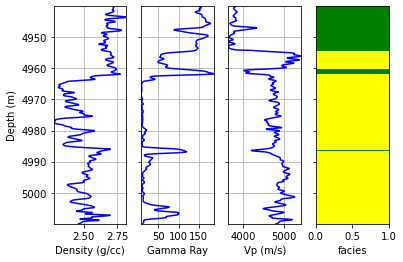

In [163]:
#plot test well (after facies prediction)
wellplot(KujungFM_target)
